### L’objectif du Notebook 
Créer un modèle Machine Learnnig qui consiste à prédire le joueur qui allait gagner un match de tennis, cela en se basant sur l’historique des matchs de tennis fourni par l’ATP.
Les différentes étapes à suivre.
* Lecture du fichier de données.
* Nettoyage et transformation des données : suppression des Features jugées sans pertinence ainsi que les features qui contiennent trop de valeurs nulles (+50%), remplacement des valeurs nulles.
* Certaines caractéristiques sont utilisables tant qu’elles, comme par exemples les statistiques des matchs (on ne peut pas utiliser les statistiques des joueurs pendant un match pour prédire le score de ce même match, il faut plutôt utiliser les statistiques des joueurs dans les matchs qui précèdent la rencontre en question).
* Création de nouvelles caractéristiques pour gérer le point ci-dessus.
* Création d’un dataSet bi-classes avec des Features pertinentes.
* Entrainer un modèle de classification supervisée sur le dataSet de données créé.
* Evaluer et tester le modèle. 


### importer des librairies

In [155]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model

### Lecture du fichier Csv

In [2]:
def readCsvFile(filename):
    dataList=[]
    file = open(filename, "r")
    reader = csv.reader(file)
    for champ in reader:
        dataList.append(champ)
    return np.array(dataList)

In [3]:
file_atp = "ATP.csv"
gamesAtp = readCsvFile(file_atp)

### Trasformer la matrice de données en DataFrame (Pandas) pour faciliter la manipulation des données

In [4]:
gamesAtppd=pd.DataFrame(gamesAtp)
gamesAatppd.columns = gamesAtppd.iloc[0]
gamesAtppd = gamesAtppd.drop(gamesAtppd.index[0])

In [5]:
gamesAtppd.head()

,best_of,draw_size,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_ace,l_bpFaced,l_bpSaved,l_df,...,winner_age,winner_entry,winner_hand,winner_ht,winner_id,winner_ioc,winner_name,winner_rank,winner_rank_points,winner_seed
1,5,64.0,,,,,,,,,...,,,R,,110023,AUS,Richard Coulthard,,,
2,5,64.0,,,,,,,,,...,27.5208761123,,R,,109803,AUS,John Brown,,,
3,5,64.0,,,,,,,,,...,16.2162902122,,R,,100257,AUS,Ross Case,,,
4,5,64.0,,,,,,,,,...,22.264202600999997,,R,,100105,AUS,Allan Stone,,,5.0
5,5,64.0,,,,,,,,,...,29.8617385352,,R,,109966,AUS,Warren Jacques,,,


#### Spliter la table de données en plusieurs table
* une table "matchTble" pour garder les garder les identifiants des jouers des matchs
* une table "playersTable" pour manipuler et transformer les caractérisqtiques des jouers et créer un dataSet d'apprentissage

In [118]:
matchTable = gamesAtppd[["loser_id","winner_id","tourney_id"]]

In [119]:
matchTable

,loser_id,winner_id,tourney_id
1,107760,110023,1968-580
2,106964,109803,1968-580
3,110024,100257,1968-580
4,110025,100105,1968-580
5,110026,109966,1968-580
6,110027,107759,1968-580
7,110028,100101,1968-580
8,108430,100025,1968-580
9,110029,108519,1968-580
10,110030,109799,1968-580


c:\users\administrator\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
c:\users\administrator\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: 'from_array' is deprecated and will be removed in a future version. Please use the pd.Series(..) constructor instead.
  


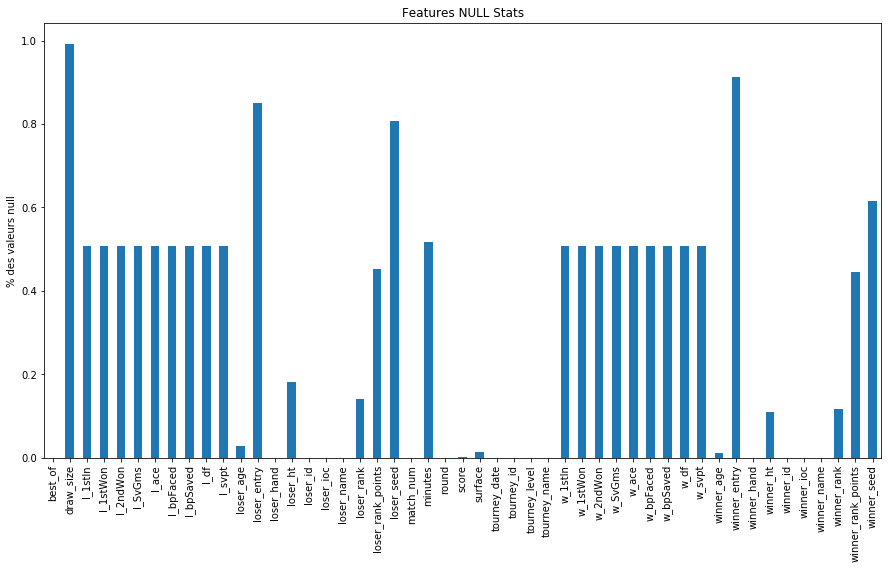

In [8]:
matrixGame=gamesAtppd.as_matrix()
list=[]
for i in range(len(aa[0])):
    res=len(np.where(matrixGame[:,i]=='')[0])
    list.append(float(res)/len(matrixGame))
ll=gamesAtppd.columns.tolist()
%matplotlib inline
freq_series = pd.Series.from_array(list)   # in my original code I create a series and run on that, so for consistency I create a series from the list.
plt.figure(figsize=(15,8))
ax = freq_series.plot(kind='bar')
ax.set_title("Features NULL Stats")
ax.set_ylabel("% des valeurs null")
rects = ax.patches
ax.set_xticklabels(ll)
plt.show()

### création d'une table joueurs pour manipuler leurs données

In [126]:
def createPlayersTable (table):
    loser = table[['loser_id','l_1stIn','l_1stWon', 'l_2ndWon', 'l_SvGms','l_ace', 'l_bpFaced',
                     'l_bpSaved', 'l_df', 'l_svpt', 'loser_age', 'loser_hand',
                     'loser_ht', 'loser_rank', 'loser_rank_points','tourney_date','tourney_level','round',"tourney_id"]]
    loser = loser.rename(columns={'loser_id':'id','l_1stIn':'1stIn','l_1stWon':'1stWon','l_2ndWon':'2ndWon',
                      'l_SvGms':'SvGms','l_ace':'ace','l_bpFaced':'bpFaced','l_bpSaved':'bpSaved',
                      'l_df':'df','l_svpt':'svpt','loser_age':'age','loser_hand':'hand',
                      'loser_ht':'ht','loser_rank':'rank',
                      'loser_rank_points':'rank_points'})
    loser.insert(len(loser.columns),'win', [0]*len(loser), True) 
    
    winner = table[['winner_id','w_1stIn', 'w_1stWon','w_2ndWon', 'w_SvGms', 'w_ace', 'w_bpFaced',
                     'w_bpSaved', 'w_df','w_svpt', 'winner_age', 'winner_hand',
                     'winner_ht',  'winner_rank','winner_rank_points','tourney_date','tourney_level','round',"tourney_id"]]
    winner = winner.rename(columns={'winner_id':'id','w_1stIn':'1stIn','w_1stWon':'1stWon','w_2ndWon':'2ndWon',
                      'w_SvGms':'SvGms','w_ace':'ace','w_bpFaced':'bpFaced','w_bpSaved':'bpSaved',
                      'w_df':'df', 'w_svpt':'svpt','winner_age':'age',
                      'winner_hand':'hand','winner_ht':'ht',
                      'winner_rank':'rank','winner_rank_points':'rank_points'})
    winner.insert(len(winner.columns),'win', [1]*len(winner), True) 
    playersTable = pd.concat([loser, winner])
    
    return playersTable

playersTable = createPlayersTable (games_atppd)  

### Remplacer les valeurs nulles avec les moyennes des colonnes

In [127]:
def replaceMissinnValuesAndRank (table):
    data2["age"] = data2["age"].replace("",np.nan).astype(float)
    table["1stIn"] = table["1stIn"].replace("",np.nan).astype(float)
    table["1stWon"] = table["1stWon"].replace("",np.nan).astype(float)
    table["2ndWon"] = table["2ndWon"].replace("",np.nan).astype(float)
    table["SvGms"] = table["SvGms"].replace("",np.nan).astype(float)
    table["ace"] = table["ace"].replace("",np.nan).astype(float)
    table["bpFaced"] = table["bpFaced"].replace("",np.nan).astype(float)
    table["bpSaved"] = table["bpSaved"].replace("",np.nan).astype(float)
    table["df"] = table["df"].replace("",np.nan).astype(float)
    table["svpt"] = table["svpt"].replace("",np.nan).astype(float)
    table["ht"] = table["ht"].replace("",np.nan).astype(float)
    table["rank"] = table["rank"].replace("",np.nan).astype(float)
    table["rank_points"] = table["rank_points"].replace("",np.nan).astype(float)
    data2["age"] = data2["age"].fillna(data2["age"].mean())
    table["1stIn"] = table["1stIn"].fillna(table["1stIn"].mean())
    table["1stWon"] = table["1stWon"].fillna(table["1stWon"].mean())
    table["2ndWon"] = table["2ndWon"].fillna(table["2ndWon"].mean())
    table["SvGms"] = table["SvGms"].fillna(table["SvGms"].mean())
    table["ace"] = table["ace"].fillna(table["ace"].mean())
    table["bpFaced"] = table["bpFaced"].fillna(table["bpFaced"].mean())
    table["bpSaved"] = table["bpSaved"].fillna(table["bpSaved"].mean())
    table["df"] = table["df"].fillna(table["df"].mean())
    table["svpt"] = table["svpt"].fillna(table["svpt"].mean())
    table["ht"] = table["ht"].fillna(table["ht"].mean())
    table["rank"] = table["rank"].fillna(table["rank"].mean())
    table["rank_points"] = table["rank_points"].fillna(table["rank_points"].mean())
    table["tourney_date"].rank() 
    table.sort_values("tourney_date", inplace = True) 
    table.reset_index(inplace=True)
    return table

playersTable = replaceMissinnValuesAndRank (playersTable)

### Création de nouvelles features

Création de nouvelles caractéristiques en aggrégant et en moyennant les statistiques des joueurs dans les matchs qui précédent le match en question.

In [128]:
def createNewFeatures (playersTable):
    playersTmp = pd.DataFrame()
    playersTmp ["id"] = playersTable["id"].unique()
    playersTmp ["count"] = 0.
    playersTmp ["1stIn"] = 0.
    playersTmp ["1stWon"] = 0.
    playersTmp ["2ndWon"] = 0.
    playersTmp ["bpFaced"] = 0.
    playersTmp ["bpSaved"] = 0.
    playersTmp ["df"] = 0.
    playersTmp ["pre_win"] = 0.
    playersTmp ["pre_loss"] = 0.
    
    playersTable ["avg_1stIn"] = 0.
    playersTable ["avg_1stWon"] = 0.
    playersTable ["avg_2ndWon"] = 0.
    playersTable ["avg_bpFaced"] = 0.
    playersTable ["avg_bpSaved"] = 0.
    playersTable ["avg_df"] = 0.
    playersTable ["avg_pre_win"] = 0.
    
    for i in range(0,len(playersTable)):
        if i % 10000 == 0:
            print(i)
        playerIndex = playersTmp.loc[(playersTmp["id"]==playersTable["id"][i])].index.values[0]
        playersTmp["count"][playerIndex]+=1
        playersTmp["1stIn"][playerIndex]+=float(playersTable["1stIn"][i])
        playersTmp["1stWon"][playerIndex]+=float(playersTable["1stWon"][i])
        playersTmp["2ndWon"][playerIndex]+=float(playersTable["2ndWon"][i])
        playersTmp["bpFaced"][playerIndex]+=float(playersTable["bpFaced"][i])
        playersTmp["bpSaved"][playerIndex]+=float(playersTable["bpSaved"][i])
        playersTmp["df"][playerIndex]+=float(playersTable["df"][i])
        playersTmp["pre_win"][playerIndex]+=float(playersTable["win"][i])

        playersTable ["avg_1stIn"][i] = float(playersTmp["1stIn"][playerIndex])/playersTmp["count"][playerIndex]
        playersTable ["avg_1stWon"][i] = float(playersTmp["1stWon"][playerIndex])/playersTmp["count"][playerIndex]
        playersTable ["avg_2ndWon"][i] = float(playersTmp["2ndWon"][playerIndex])/playersTmp["count"][playerIndex]
        playersTable ["avg_bpFaced"][i] = float(playersTmp["bpFaced"][playerIndex])/playersTmp["count"][playerIndex]
        playersTable ["avg_bpSaved"][i] = float(playersTmp["bpSaved"][playerIndex])/playersTmp["count"][playerIndex]
        playersTable ["avg_df"][i] = float(playersTmp["df"][playerIndex])/playersTmp["count"][playerIndex]
        playersTable ["avg_pre_win"][i] = float(playersTmp["pre_win"][playerIndex])/playersTmp["count"][playerIndex]

    return playersTable

playersTable = createNewFeatures (playersTable)

0


c:\users\administrator\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\administrator\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\administrator\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000


### Représenter les valeurs qualitatives par des vecteurs binaires 

In [129]:
def qualitatifToVectorelRepresentation (playersTable):
    playersTable["r_hand"]=0
    playersTable["l_hand"]=0
    playersTable["g_level"]=0
    playersTable["m_level"]=0
    playersTable["a_level"]=0
    playersTable["c_level"]=0
    playersTable["s_level"]=0
    playersTable["f_level"]=0
    playersTable["d_level"]=0

    for i in range (len(playersTable)):
        if i % 10000 == 0:
            print(i)
        if playersTable["hand"][i]=="R":
            playersTable["r_hand"][i]=1
        elif playersTable["hand"][i]=="L":
            playersTable["l_hand"][i]=1

        if playersTable["tourney_level"][i]=="G":
            playersTable["g_level"][i]=1
        elif playersTable["tourney_level"][i]=="M":
            playersTable["m_level"][i]=1
        elif playersTable["tourney_level"][i]=="A":
            playersTable["a_level"][i]=1
        elif playersTable["tourney_level"][i]=="C":
            playersTable["c_level"][i]=1
        elif playersTable["tourney_level"][i]=="S":
            playersTable["s_level"][i]=1
        elif playersTable["tourney_level"][i]=="F":
            playersTable["f_level"][i]=1
        elif playersTable["tourney_level"][i]=="D":
            playersTable["d_level"][i]=1

    return playersTable
playersTable = qualitatifToVectorelRepresentation (playersTable)

0


c:\users\administrator\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
c:\users\administrator\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\administrator\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

10000
20000
30000
40000
50000
60000
70000
80000
90000


c:\users\administrator\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000


### Sélection  des features à utiliser dans l'apprentissage

In [130]:
playersDataSelected = playersTable [["id","tourney_id","age","ht","rank","rank_points","avg_1stIn","avg_1stWon","avg_2ndWon","avg_bpFaced","avg_bpSaved","avg_df","avg_pre_win","r_hand","l_hand","g_level","m_level","c_level","s_level","f_level","d_level"]]

### Création des classes
Nos données ne contiennent pour l'instant que des exmple positive (+1) ou c'est à chaque fois le joueur2 qui gagne contre le joueur1, mais en inversant leurs ordre dans les lignes de données, on obtient des exmples negatifs.
c'est ce que nous allons faire avec une fonction aléatoire uniforme

In [121]:
matchTable["label"]=None
for i in range (len(matchTable)):
    if i % 10000 == 0:
        print(i)
    r = np.random.random()
    if r>=0.5:
        matchTable["label"][i]=1
    else:
        tmpValue=matchTable["loser_id"][i]
        matchTable["loser_id"][i]=matchTable["winner_id"][i]
        matchTable["winner_id"][i]=tmpValue
        matchTable["label"][i]=-1

c:\users\administrator\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000


### jointure entre matchs et joueurs

In [ ]:
data1=pd.merge(playersDataSelected,matchTable,left_on=['id',"tourney_id"],right_on=['loser_id',"tourney_id"])
data2=pd.merge(playersDataSelected,data1,left_on=['id',"tourney_id"],right_on=['winner_id',"tourney_id"])

In [173]:
dataToLearn = data2[['age_x','ht_x', 'rank_x', 'rank_points_x',
       'avg_1stIn_x', 'avg_1stWon_x', 'avg_2ndWon_x', 'avg_bpFaced_x',
       'avg_bpSaved_x', 'avg_df_x', 'avg_pre_win_x', 'r_hand_x', 'l_hand_x',
       'g_level_x', 'm_level_x', 'c_level_x', 's_level_x', 'f_level_x',
       'd_level_x','age_y', 'ht_y', 'rank_y', 'rank_points_y',
       'avg_1stIn_y', 'avg_1stWon_y', 'avg_2ndWon_y', 'avg_bpFaced_y',
       'avg_bpSaved_y', 'avg_df_y', 'avg_pre_win_y', 'r_hand_y', 'l_hand_y',
       'g_level_y', 'm_level_y', 'c_level_y', 's_level_y', 'f_level_y',
       'd_level_y']]
label = data2[ "label"]

### Data frame to Matrix

In [210]:
dataFinal=dataToLearn.as_matrix()
labelFinal = label.as_matrix()
labelFinal = labelFinal.tolist()
for i in range (len(labelFinal)):
    if labelFinal[i] == None:
        labelFinal[i]=-1

c:\users\administrator\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
c:\users\administrator\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


### Learning with Logistic Regression

In [213]:
splitValue = int(len(dataFinal)*0.7)
trainX = dataFinal [0:splitValue]
trainY = labelFinal [0:splitValue]
testX = dataFinal [splitValue:len(dataFinal)]
testY = labelFinal [splitValue:len(labelFinal)]

In [214]:
clf_LR=linear_model.logistic.LogisticRegression()
clf_LR.fit (trainX,trainY)

c:\users\administrator\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

### Prediction

In [223]:
prediction = clf_LR.predict(testX)

In [224]:
len(np.where (prediction==testY)[0])/len(testY)

0.7097078887528424

### Perspectives

Ce que je peux faire de plus:
* Choisir une maniéré  plus personnalisée pour replacer les valeurs nulles (domaine expertise).
* Calculer d'autres caractéristiques à utiliser dans le dataSet d'entrainement, qui peuvent être pertinentes.
* Faire du feature engineering pour sélectionner les caractéristiques les pertinentes, au lieu de choisir le tout par défaut.
* Utilisation de fonction de traitement de données qui coûte moins en temps de calcule.
* Tester plusieurs modèles de classification (SVM, Random Forest, Boosting, ...) à fin de choisir le plus efficace.
* Tester plusieurs paramètres pour les modèle d'apprentissage.
* Faire de la cross validation pour avoir des scores plus fiables.
* Créer le projet sous forme d'une classe qui contient les différentes fonctions.
* Utiliser des containers (docker) pour permettre une réutilisation et une scalabilité du projet. 



* Trouver une meilleur stratégie de pari sportif en combinant les matchs les plus sûrs en score de prédiction.